# Gam control experiments

In [1]:
from pyberries.data import DatasetPool, Fit, get_histogram
import seaborn.objects as so
from seaborn import plotting_context

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['240227_1', '240227_2', '240227_3',
                            '230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2', '240424_1', '240612_1', '240620_1',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec', '240424_2', '240612_2', '240620_2',
                            '240227_4', '240301_1', '240301_2'
                            ],
                    groups=['0 ng/ml, Gam', '0 ng/ml, Gam', '0 ng/ml, Gam',
                            '0 ng/ml, WT', '0 ng/ml, WT', '0 ng/ml, WT', '0 ng/ml, WT', '0 ng/ml, WT', '0 ng/ml, WT', '0 ng/ml, WT', '0 ng/ml, WT',
                            '30 ng/ml, WT', '30 ng/ml, WT', '30 ng/ml, WT', '30 ng/ml, WT', '30 ng/ml, WT', '30 ng/ml, WT', '30 ng/ml, WT', '30 ng/ml, WT', '30 ng/ml, WT', '30 ng/ml, WT', '30 ng/ml, WT', '30 ng/ml, WT',
                            '30 ng/ml, Gam', '30 ng/ml, Gam', '30 ng/ml, Gam'
                            ],
                    metadata='DateTime',
                    filters={'all':'Frame < 50'},
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .split_column(col='Group', new_cols=['Cipro', 'Strain'], delimiter=', ')
        .assign(Cipro=lambda df: df.Cipro.astype('category').cat.set_categories(['0 ng/ml', '30 ng/ml'], ordered=True),
                Strain=lambda df: df.Strain.astype('category').cat.set_categories(['WT', 'Gam'], ordered=True),
                Group=lambda df: df.Group.astype('category').cat.set_categories(['0 ng/ml, WT', '0 ng/ml, Gam', '30 ng/ml, WT', '30 ng/ml, Gam'], ordered=True)
                )
        )

Dataset 240227_1 (group 0 ng/ml, Gam): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240227_2 (group 0 ng/ml, Gam): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240227_3 (group 0 ng/ml, Gam): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230725_1 (group 0 ng/ml, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2 (group 0 ng/ml, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23 (group 0 ng/ml, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1 (group 0 ng/ml, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2 (group 0 ng/ml, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_1 (group 0 ng/ml, WT): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group 0 ng/ml, WT): loaded objects ['Bacteria_large', 'RecB_spots'

## General statistics

Number of cells (Gam only)

In [3]:
display(data
        .Bacteria_large
        .query('Frame == 0 and Strain == "Gam"')
        .agg({'Indices':'count'})
        )

Indices    8812
dtype: int64

Number of spots (Gam only)

In [4]:
display(data
        .RecB_spots
        .query('Strain == "Gam"')
        .agg({'Indices':'count'})
        )

Indices    18698
dtype: int64

Total number of cells

In [5]:
display(data
        .Bacteria_large
        .query('Frame == 0')
        .agg({'Indices':'count'})
        )

Indices    41403
dtype: int64

## Cell length

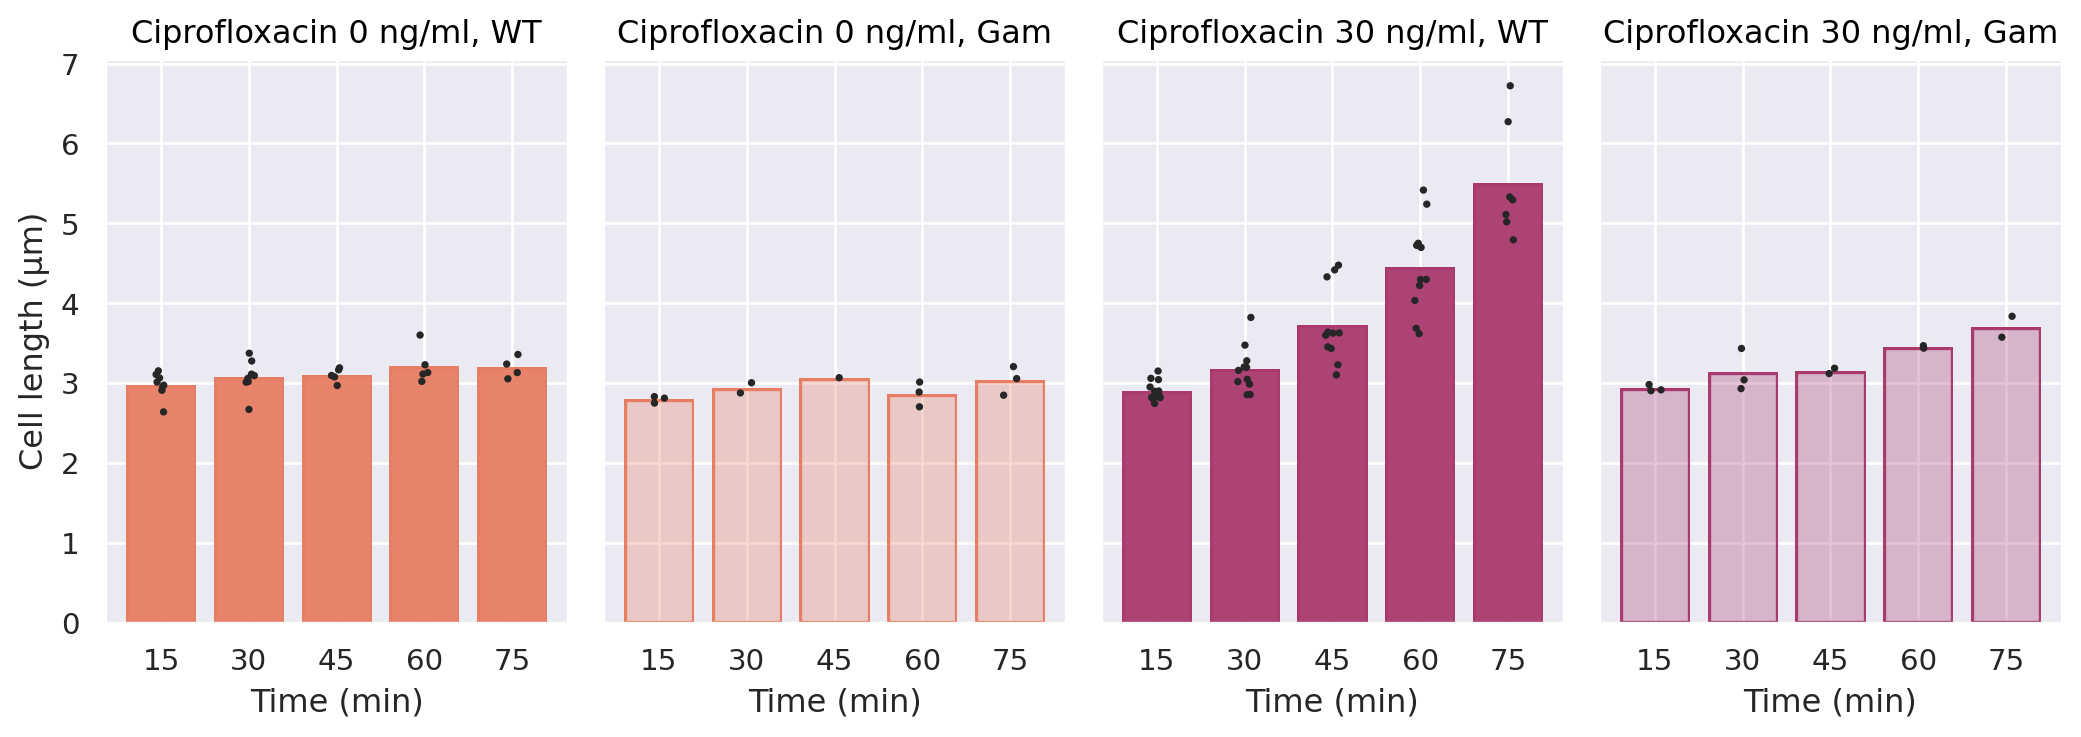

In [19]:
df = (data
      .Bacteria_large
      .groupby(['Group', 'Cipro', 'Strain', 'Dataset', 'Time_min_bin'], observed=True)
      .agg({'SpineLength':'mean'})
      .query('Time_min_bin <= 75')
      )

(
 so.Plot(df, x='Time_min_bin', y='SpineLength', color='Cipro', alpha='Strain')
 .layout(size=(11, 4))
 .facet(col='Group')
 .add(so.Bar(), so.Agg(), legend=False)
 .add(so.Dots(color='k', marker='.', fillalpha=1, alpha=1), so.Jitter(), legend=False)
 .scale(color=so.Nominal('flare', order=['0 ng/ml', '', '', '30 ng/ml']), x=so.Continuous().tick(every=15))
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Cell length (µm)", title='Ciprofloxacin {}'.format, color='Ciprofloxacin', alpha='Strain')
#  .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Cell_length_Gam.pdf', format='pdf', bbox_inches='tight')
 )

## RecB lifetime histograms

In [43]:
hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset','Group','Cipro','Strain'], density=True, binlabels='left')
monoexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='monoexp_decay',
                   groupby=['Dataset','Group','Cipro','Strain'], p0=[1, 0.1])

/media/daniel/HDD Daniel/DanielThedie/Python/PyBerries/pyberries/data/Fitting.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, data in df_in.groupby(groupby, sort=False):


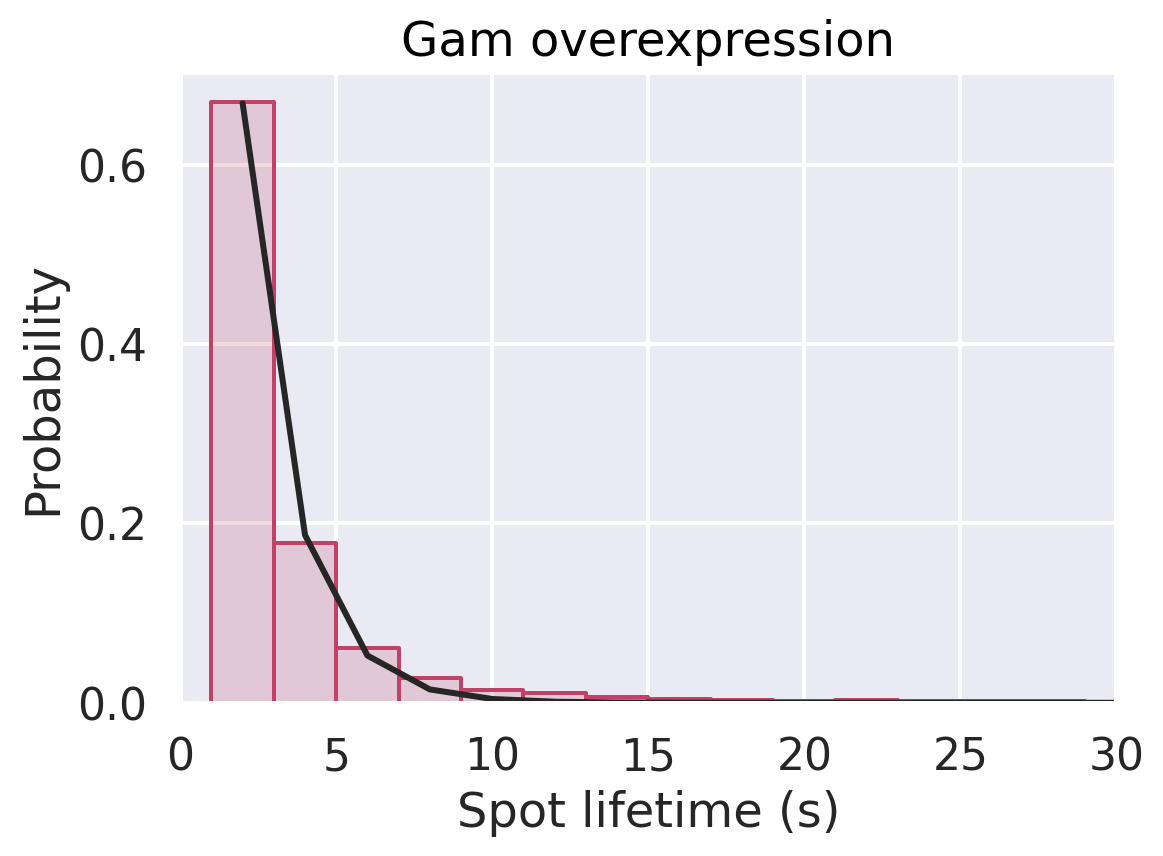

In [56]:
df = (monoexp_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength*2)
      .query('Group == "30 ng/ml, Gam"')
      )

(
    so.Plot(df, x='TrackLength_s', y='proportion', color='Strain', edgecolor='Cipro')
    .add(so.Bars(alpha=.2, edgewidth=1.5, edgestyle='-'), so.Agg(), so.Dodge(), legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .scale(x=so.Continuous(), color='flare', edgecolor='flare')
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (s)", y="Probability", color='Ciprofloxacin', title='Gam overexpression')
    .theme(plotting_context('talk'))
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Presentations/241002_SMBacIII/Gam_monoexp_fit.svg', format='svg', bbox_inches='tight')
)

### Define a threshold so that 95% of RecB spots in Gam experiments are shorter

TrackLength_s    10.0
dtype: float64

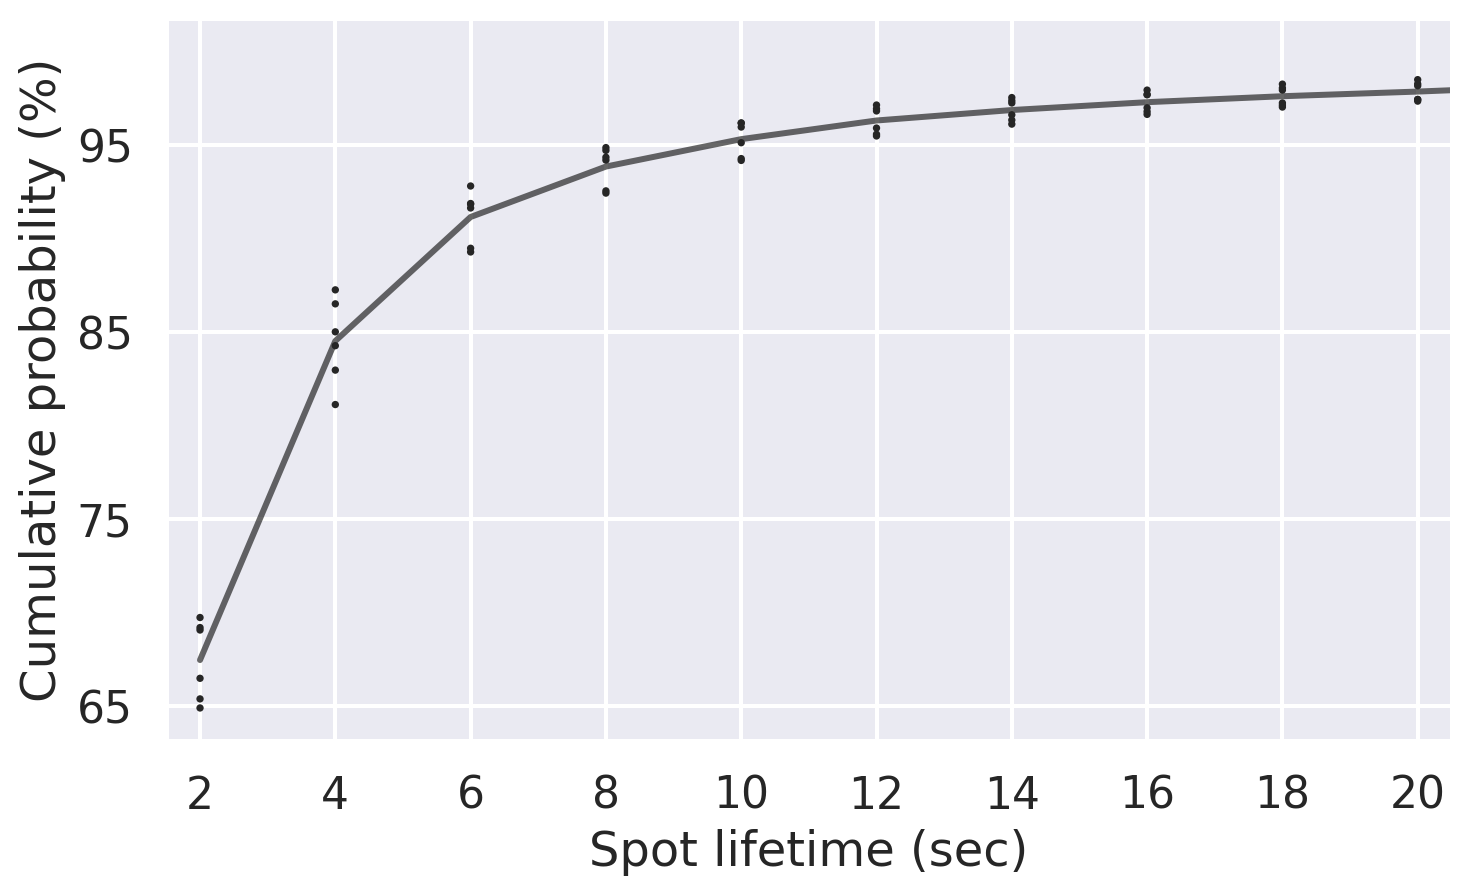

In [17]:
import pandas as pd
import seaborn.objects as so
from seaborn import plotting_context
import numpy as np

df = (hist
      .query('Strain == "Gam"')
      .sort_values('TrackLength')
      .assign(Sum_shorter=lambda df: df.groupby('Dataset')['proportion'].cumsum().mul(100),
              TrackLength_s=lambda df: df.TrackLength*2
              )
      )

display(df.query('Sum_shorter > 95').groupby('Dataset').agg({'TrackLength_s':'min'}).median())

(
    so.Plot(df, x='TrackLength_s', y='Sum_shorter')
    .layout(size=(8, 5))
    .add(so.Line(color='k', alpha=0.7), so.Agg())
    .add(so.Dots(color='k', marker='.', fillalpha=1))
    .scale(x=so.Continuous().tick(every=2), y=so.Continuous().tick(at=[65, 75, 85, 95]))
    .limit(x=(1.5, 20.5))
    .label(x='Spot lifetime (sec)', y='Cumulative probability (%)')
    .theme(plotting_context("talk"))
    # .save('/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Gam_thresholding.svg', format='svg', bbox_inches='tight')
)

### Bi-exponential fit

In [2]:
hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset','Group','Cipro','Strain'], density=True, binlabels='left')
biexp_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                   groupby=['Dataset','Group','Cipro','Strain'], p0=[1, 1, 0.1, 0.1], bootstrap_samples=20)

Group ('240227_1', '0 ng/ml, Gam', '0 ng/ml', 'Gam'): 7 iterations failed
Group ('240227_3', '0 ng/ml, Gam', '0 ng/ml', 'Gam'): 3 iterations failed
Group ('230719_1', '0 ng/ml, WT', '0 ng/ml', 'WT'): 2 iterations failed
Group ('240424_1', '0 ng/ml, WT', '0 ng/ml', 'WT'): 1 iterations failed
Group ('240612_1', '0 ng/ml, WT', '0 ng/ml', 'WT'): 5 iterations failed
Group ('240620_1', '0 ng/ml, WT', '0 ng/ml', 'WT'): 2 iterations failed
Group ('230118_DT23', '30 ng/ml, WT', '30 ng/ml', 'WT'): 1 iterations failed
Group ('230726_cipro30', '30 ng/ml, WT', '30 ng/ml', 'WT'): 1 iterations failed
Group ('230824_1', '30 ng/ml, WT', '30 ng/ml', 'WT'): 1 iterations failed
Group ('230829_1', '30 ng/ml, WT', '30 ng/ml', 'WT'): 1 iterations failed
Group ('230201_DT23', '30 ng/ml, WT', '30 ng/ml', 'WT'): 1 iterations failed
Group ('230504_2sec', '30 ng/ml, WT', '30 ng/ml', 'WT'): 1 iterations failed
Group ('240612_2', '30 ng/ml, WT', '30 ng/ml', 'WT'): 2 iterations failed
Group ('240227_4', '30 ng/ml, G

#### Show fit components

In [3]:
from pyberries.data import get_model
import pandas as pd

monoexp_decay = get_model('monoexp_decay')

biexp_fit.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for ds, df in biexp_fit.data.groupby('Dataset'):
    params = biexp_fit.parameters.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    biexp_fit.data.loc[biexp_fit.data.Dataset == ds,:] = df

In [4]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes = (biexp_fit
             .parameters
             .copy()
             .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
             .replace({'1':'Short', '2':'Long'})
             .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Group', 'Dataset'], columns=['Parameter', 'Rate_type']))
             .reset_index()
             .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short) *2,
                     Lifetime_Long=lambda df: 1/(df.Value.Rate.Long) *2,
                     Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                     Population_Short=lambda df: 100 - df.Population_Long
                     )
             .drop(columns=['Value'], level=0)
             .droplevel(['Parameter', 'Rate_type'], axis=1)
             .melt(id_vars=['Group', 'Dataset'])
             .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
             .drop(columns='variable')
             )

In [25]:
def fuse_cols(df, cols, new, delimiter):
        df[new] = (df[cols]
                   .astype('str')
                   .agg(delimiter.join, axis=1)
                   )
        return df

df = (lifetimes
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Group', 'Dataset', 'Rate_type'], columns='Parameter'))
      .groupby(['Group', 'Rate_type'], observed=True)
      .agg(Lifetime_mean=('Lifetime', 'mean'),
           Lifetime_std=('Lifetime', 'std'),
           Population_mean=('Population', 'mean'),
           Population_std=('Population', 'std')
           )
      .round(1)
      .pipe(lambda df: fuse_cols(df, cols=['Lifetime_mean', 'Lifetime_std'], new='Lifetime (sec)', delimiter=' $\pm$ '))
      .pipe(lambda df: fuse_cols(df, cols=['Population_mean', 'Population_std'], new='Proportion (\%)', delimiter=' $\pm$ '))
      [['Lifetime (sec)', 'Proportion (\%)']]
      .rename_axis(['Ciprofloxacin', 'Population'])
      .reindex(['Short', 'Long'], level=1)
      )

display(df)

Lifetime (sec) Proportion (\%)
Ciprofloxacin Population                                
0 ng/ml, Gam  Short        1.6 $\pm$ 0.2  99.0 $\pm$ 0.6
              Long        12.6 $\pm$ 7.3   1.0 $\pm$ 0.6
0 ng/ml, WT   Short        1.4 $\pm$ 0.2  98.4 $\pm$ 0.8
              Long         9.0 $\pm$ 2.6   1.6 $\pm$ 0.8
30 ng/ml, Gam Short        1.5 $\pm$ 0.1  98.6 $\pm$ 0.5
              Long         8.8 $\pm$ 0.9   1.4 $\pm$ 0.5
30 ng/ml, WT  Short        1.7 $\pm$ 0.3  94.3 $\pm$ 1.2
              Long         9.8 $\pm$ 1.4   5.7 $\pm$ 1.2

#### Showing only Gam data

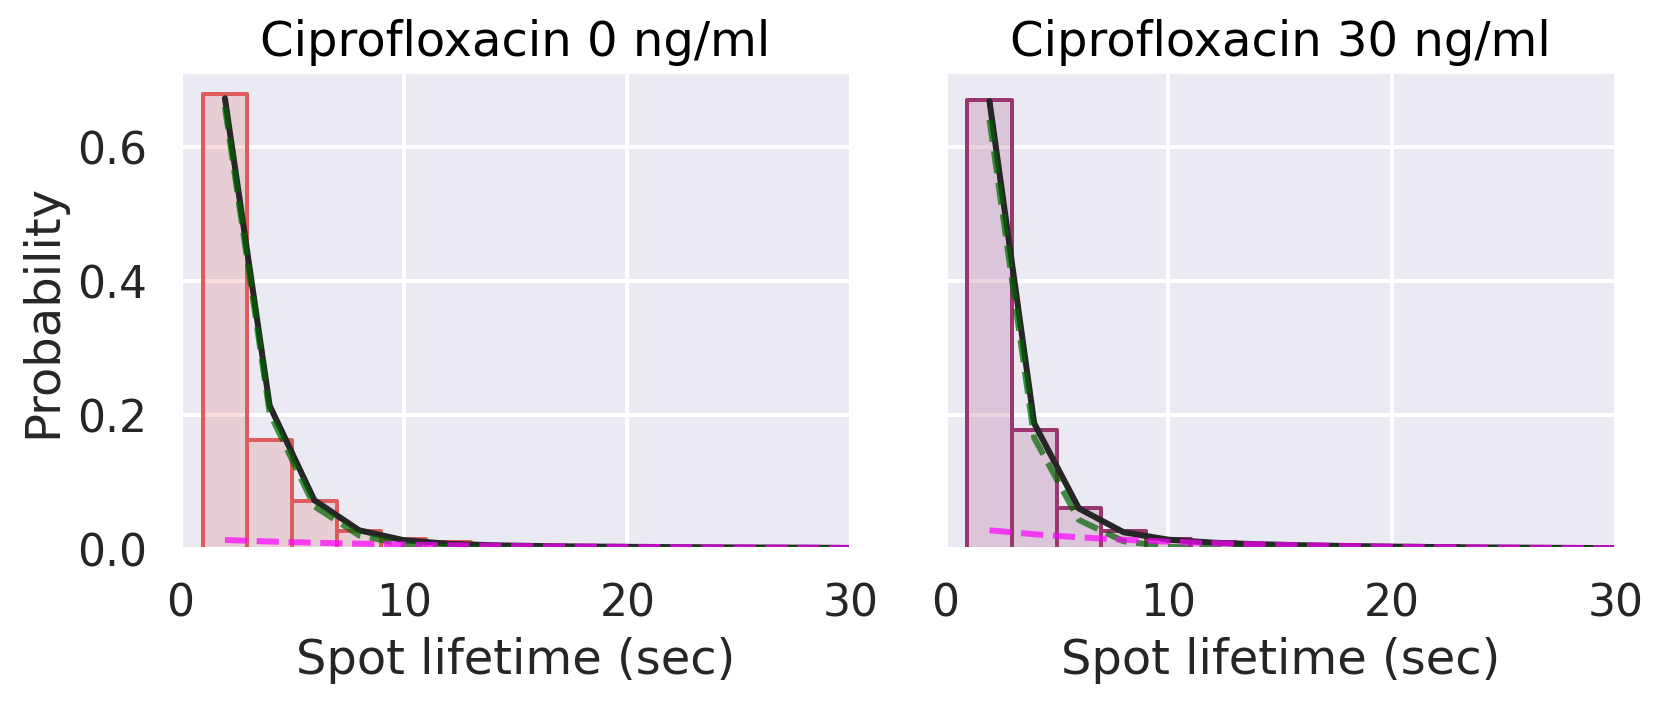

In [7]:
import seaborn.objects as so
from seaborn import plotting_context

df = (biexp_fit
      .data
      .assign(TrackLength_s=lambda df:df.TrackLength *2)
      .query("Strain == 'Gam'")
      )

(
    so.Plot(df, x='TrackLength_s', edgecolor='Cipro', color='Cipro')
    .layout(size=(9,4))
    .facet(col='Cipro')
    .add(so.Bars(alpha=0.2, edgewidth=1.5, edgestyle='-'), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k', alpha=1), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .scale(color='flare', edgecolor='flare')
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    .theme(plotting_context('talk'))
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Gam_lifetimes_fits_A.svg', format='svg', bbox_inches='tight')
)

Zoom on the histogram tail

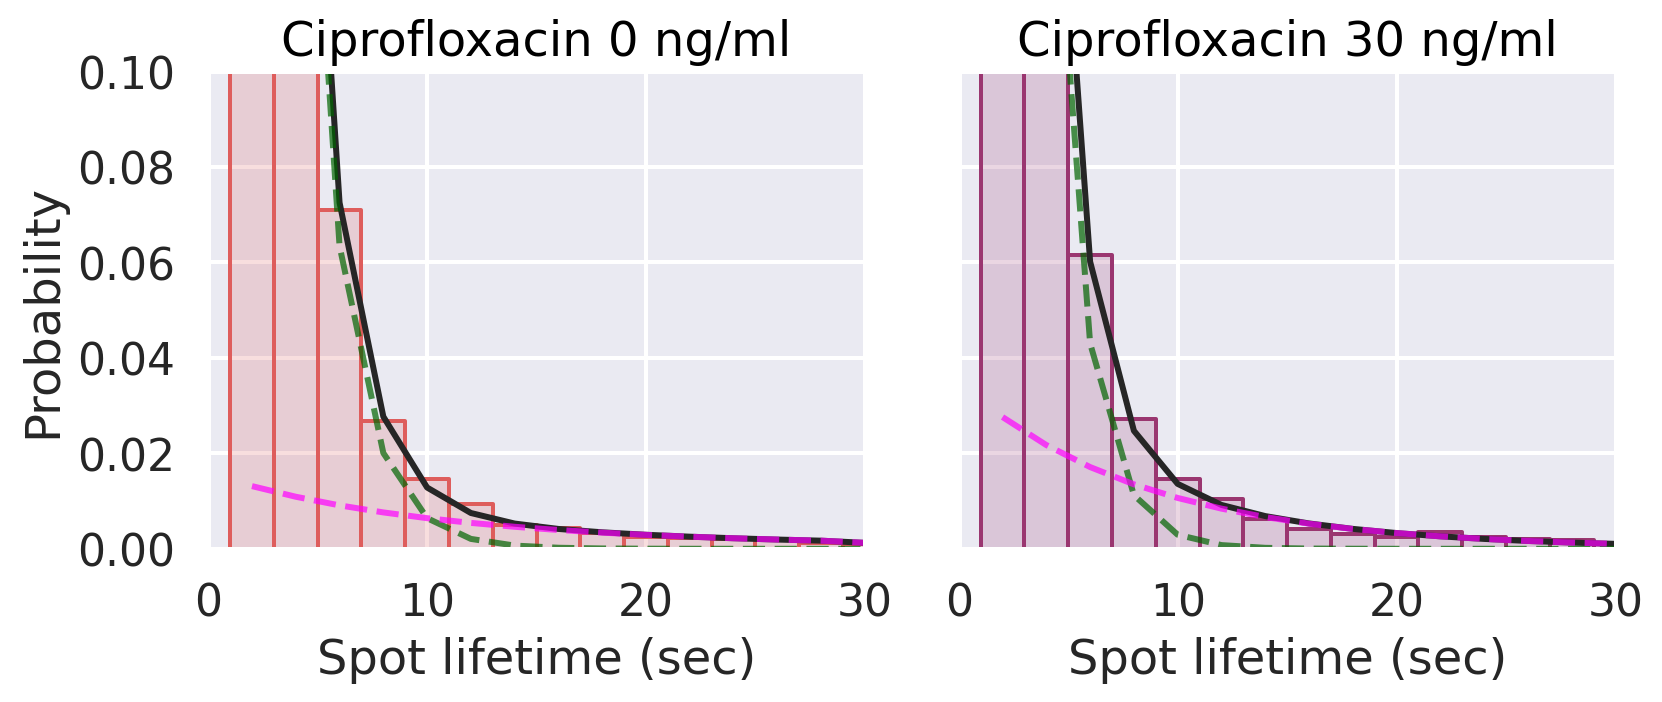

In [8]:
import seaborn.objects as so
from seaborn import plotting_context

df = (biexp_fit
      .data
      .assign(TrackLength_s=lambda df:df.TrackLength *2)
      .query("Strain == 'Gam'")
      )

(
    so.Plot(df, x='TrackLength_s', edgecolor='Cipro', color='Cipro')
    .layout(size=(9,4))
    .facet(col='Cipro')
    .add(so.Bars(alpha=0.2, edgewidth=1.5, edgestyle='-'), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k', alpha=1), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .scale(color='flare', edgecolor='flare')
    .limit(x=(0, 30), y=(None, 0.1))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    .theme(plotting_context('talk'))
    .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Gam_lifetimes_fits_B.svg', format='svg', bbox_inches='tight')
)